Using device: cpu
Total dataset size: 16000
Classes: ['F_Banana', 'F_Lemon', 'F_Lulo', 'F_Mango', 'F_Orange', 'F_Strawberry', 'F_Tamarillo', 'F_Tomato', 'S_Banana', 'S_Lemon', 'S_Lulo', 'S_Mango', 'S_Orange', 'S_Strawberry', 'S_Tamarillo', 'S_Tomato']
Batch image shape: torch.Size([64, 3, 128, 128])
Batch label shape: torch.Size([64])
Total trainable parameters: 24,692,560
Starting ResNet-50 Training (5 Epochs)


Epoch 1/5 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Accuracy: 99.58%
🎯 New Best Accuracy: 99.58%


Epoch 2/5 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Accuracy: 99.83%
🎯 New Best Accuracy: 99.83%


Epoch 3/5 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Accuracy: 99.46%


Epoch 4/5 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Accuracy: 100.00%
🎯 New Best Accuracy: 100.00%


Epoch 5/5 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Accuracy: 99.75%


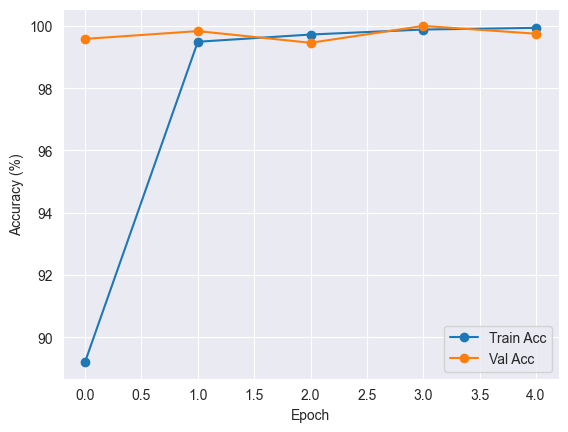

Final Testing:   0%|          | 0/38 [00:00<?, ?it/s]


Test Accuracy: 100.00%
✅ Final Test Accuracy: 100.00%


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import random
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# CPU Setup
device = torch.device("cpu")
print(f"Using device: {device}")
torch.set_num_threads(4)
torch.manual_seed(42)

# Data Transformations
Image_Transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
dataset_path = "FRUIT-16K"
dataset = datasets.ImageFolder(root=dataset_path, transform=Image_Transform)
print(f"Total dataset size: {len(dataset)}")
print(f"Classes: {dataset.classes}")
num_classes = len(dataset.classes)

# Split Data
train_size = int(0.7*len(dataset))
test_size = int(0.15*len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
batch_size = 64  # increased for speed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Preview a Batch
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    break

# =======================
# MODEL: ResNet-50
# =======================
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

# Load pretrained ResNet-50
resnet_model = resnet50(pretrained=True)

# Unfreeze all layers
for param in resnet_model.parameters():
    param.requires_grad = True

# Custom classifier head
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

# Move to device
model = resnet_model.to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

# Loss & Optimizer
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

# Training Function
def train_model(model, loss_fn, optimizer, scheduler, epochs=5):
    best_val_acc = 0.0
    train_acc_list = []
    val_acc_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{100.*correct_train/total_train:.1f}%'})

        scheduler.step()
        train_acc = 100. * correct_train / total_train
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False)
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100. * correct / total
        val_acc_list.append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet50_cpu.pth')
            print(f"🎯 New Best Accuracy: {best_val_acc:.2f}%")

    # Plot Accuracies
    plt.plot(train_acc_list, label='Train Acc', marker='o')
    plt.plot(val_acc_list, label='Val Acc', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train
print("="*50)
print("Starting ResNet-50 Training (5 Epochs)")
print("="*50)
train_model(model, loss_fn, optimizer, scheduler, epochs=5)

# Test Function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Final Testing')
        for images, labels in test_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_pbar.set_postfix({'Acc': f'{100.*correct/total:.2f}%'})

    test_acc = 100. * correct / total
    print(f"\nTest Accuracy: {test_acc:.2f}%")
    return test_acc

# Load Best Model and Test
model.load_state_dict(torch.load('best_resnet50_cpu.pth'))
final_test_accuracy = test_model(model, test_loader)
print(f"✅ Final Test Accuracy: {final_test_accuracy:.2f}%")
